In [198]:
import pandas as pd
import glob

import os
from skimage import io, measure, morphology, color, filters, transform
import numpy as np

from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
from statsmodels.tsa.api import SimpleExpSmoothing

import porespy as ps

from scipy.signal import argrelextrema
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.signal import find_peaks

## Split text by unique word's contours (unsuccessful)

In [2]:
def rgb2smyk(bgr):
    bgrdash = bgr.astype(np.float32)/255.

    # Calculate K as (1 - whatever is biggest out of Rdash, Gdash, Bdash)
    K = 1 - np.max(bgrdash, axis=2)

    # Calculate C
    C = (1-bgrdash[...,2] - K)/(1-K)

    # Calculate M
    M = (1-bgrdash[...,1] - K)/(1-K)

    # Calculate Y
    Y = (1-bgrdash[...,0] - K)/(1-K)

    K*=255
    K=K.astype(np.uint8)

    C*=255
    C=C.astype(np.uint8)

    M*=255
    M=M.astype(np.uint8)

    Y*=255
    Y=Y.astype(np.uint8)

    return C,M,Y,K

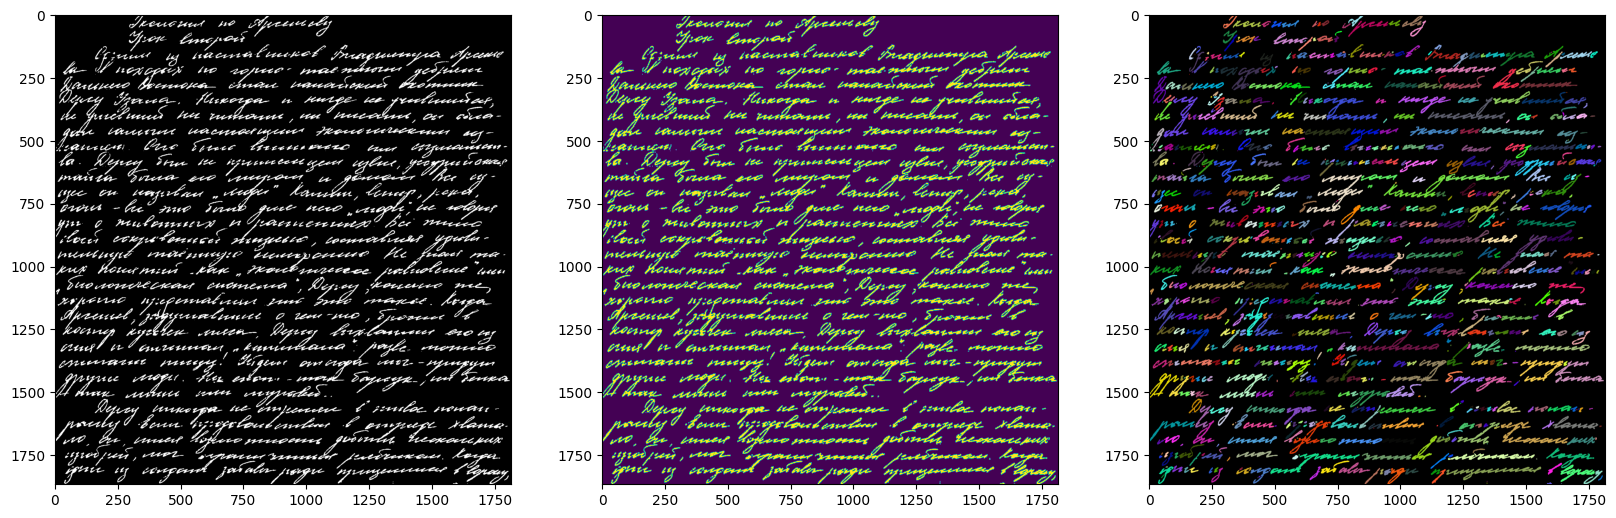

In [3]:
# name='62263_1.jpg'
name='00200_163.jpg'

img=io.imread(name)

# for k in range(N_lines):


(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# thresh=threshold_otsu(Y)
thresh*=0.8
binaryImage=Y>thresh

binaryImage=binaryImage*255
binaryImage=binaryImage.astype(np.uint8)

# binaryImage=morphology.binary_dilation(binaryImage, morphology.disk(1))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 3))

dilated_image = cv2.dilate(binaryImage, kernel)

labeled_image = measure.label(dilated_image)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(binaryImage, cmap='gray')
ax2.imshow(dilated_image)
ax3.imshow(colored_img)
plt.show()

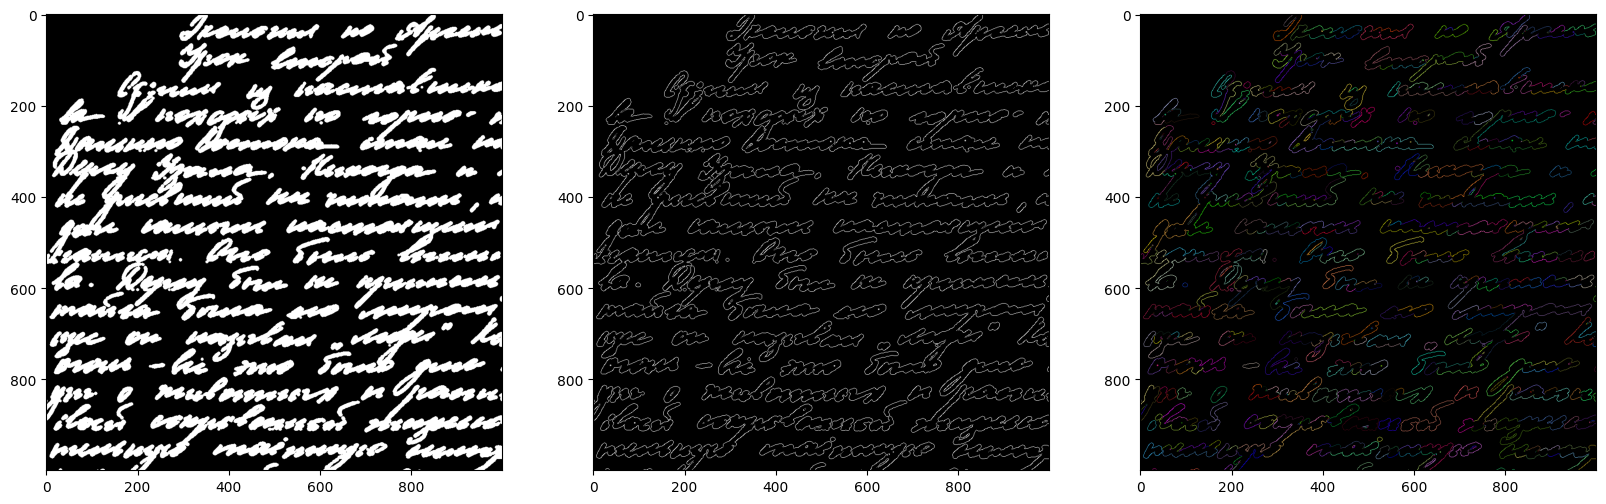

In [4]:
# name='62263_1.jpg'
name='00200_163.jpg'
img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh*=0.8
binaryImage=Y>thresh

dilated_image=morphology.binary_dilation(binaryImage, morphology.disk(3))

dilated_image=dilated_image*255
dilated_image=dilated_image.astype(np.uint8)


edges = cv2.Canny(dilated_image, 0, 255, L2gradient=False)

# направление обхода контура по часовой стрелке
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
new_contours = []
for cnt in contours:
    new_contours.append(np.array(cnt).reshape((-1, 2)))

labeled_image = measure.label(edges)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(dilated_image[:1000,:1000], cmap='gray')
ax2.imshow(edges[:1000,:1000], cmap='gray')
ax3.imshow(colored_img[:1000,:1000])
plt.show()

## Slope (in progress)

In [5]:
def chaincode(b, unwrap=False):
    '''
    Direction-to-code convention:
    --------------------------
    | deltax | deltay | code |
    |------------------------|    y
    |    0   |   +1   |   2  |    ^     3  2  1
    |    0   |   -1   |   6  |    |      \ | /
    |   -1   |   +1   |   3  |    |   4 -- P -- 0
    |   -1   |   -1   |   5  |    |      / | \ \
    |   +1   |   +1   |   1  |    |     5  6  7
    |   +1   |   -1   |   7  |    |
    |   -1   |    0   |   4  |    +-------------> x
    |   +1   |    0   |   0  |
    --------------------------
    '''
    delta = np.zeros(b.shape, dtype=int)
    delta[:-1, :] = b[1:, :] - b[:-1, :]
    delta[-1, :] = b[0, :] - b[-1, :]

    # check if boundary is 8-connected
    if ((np.abs(delta[:, 0]) > 1) + (np.abs(delta[:, 1]) > 1)).any():
        raise ValueError('Curve is not 8-connected.')

    # check if boundary is close, if so cut last element
    if (np.abs(delta[-1, :]) == 0).all():
        delta = delta[:-1, :]

    if ((np.abs(delta[:, 0]) == 0) * (np.abs(delta[:, 1]) == 0)).any():
        raise ValueError('Curve is degenerate.')

    idx = 3 * delta[:, 0] + delta[:, 1] + 4
    cm = np.array([5, 6, 7, 4, -1, 0, 3, 2, 1])
    cc = cm[idx]

    if unwrap:
        ucc = cc.copy()
        for i in range(1, ucc.shape[0]):
            ucc[i] += 8*np.round((ucc[i-1] - cc[i])/8.)
        return cc, b[0, :], ucc
    else:
        # return cc, b[0, :]
        return cc

In [179]:
def chain_plots(name):
    img=io.imread(name)

    (C, M, Y, K) = rgb2smyk(img)

    thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    thresh*=0.8
    binaryImage=Y>thresh

    dilated_image=morphology.binary_dilation(binaryImage, morphology.disk(3))

    dilated_image=dilated_image*255
    dilated_image=dilated_image.astype(np.uint8)


    edges = cv2.Canny(dilated_image, 0, 255, L2gradient=False)

    # направление обхода контура по часовой стрелке
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    new_contours = []

    for cnt in contours:
        if len(cnt)>5:
            new_contours.append(np.array(cnt).reshape((-1, 2)))

    freeman_chains=[]
    for cnt in new_contours:
        freeman_chains.extend(chaincode(cnt))

    freeman_pairs=np.zeros((8,8))
    for cnt in new_contours:
        chain=chaincode(cnt)
        freeman_pairs[chain[:-1],chain[1:]]+=1

    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(20,3))
    ax1.hist(freeman_chains,bins=8)

    # fr=np.sort(freeman_pairs.flatten())
    fr=freeman_pairs.flatten()
    ax6.plot(fr)
    # fr2 = SimpleExpSmoothing(fr).fit(smoothing_level=0.3,optimized=False).fittedvalues
    ax2.plot(freeman_pairs[:,2])
    # ax2.plot(freeman_pairs[:,2],freeman_pairs[:,6])
    ax2.plot(freeman_pairs[:,6])
    ax3.plot(freeman_pairs[:,1])
    # ax3.plot(freeman_pairs[:,1],freeman_pairs[:,5])
    ax3.plot(freeman_pairs[:,5])
    ax4.plot(freeman_pairs[:,3])
    # ax4.plot(freeman_pairs[:,3],freeman_pairs[:,7])
    ax4.plot(freeman_pairs[:,7])
    ax5.plot(freeman_pairs[:,4])
    # ax5.plot(freeman_pairs[:,4],freeman_pairs[:,0])
    ax5.plot(freeman_pairs[:,0])


    plt.show()

In [ ]:
# name='62263_1.jpg'
# name='67205_2.jpg'
# name='00201_73.jpg'
# name='67205_3.jpg'
name='62325_1_12.jpg'
# name='00200_163.jpg'

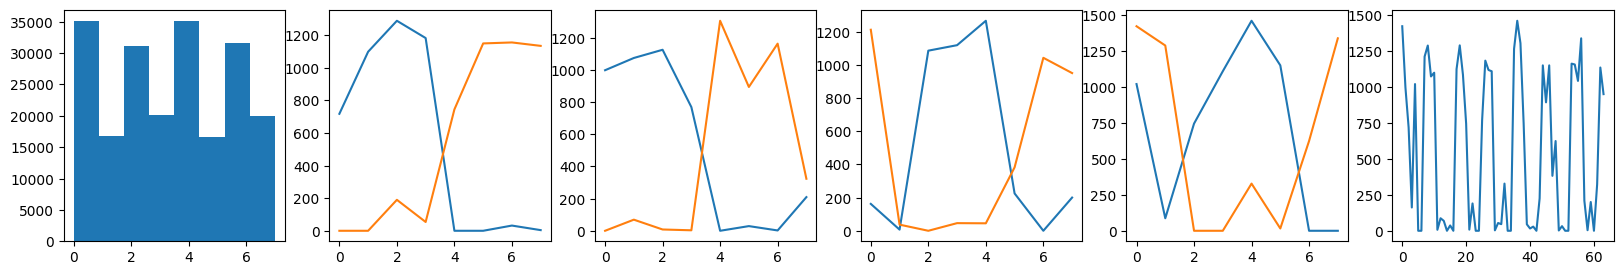

In [180]:
# '62325_1_12.jpg'
#  ровный

name='62325_1_12.jpg'

chain_plots(name)

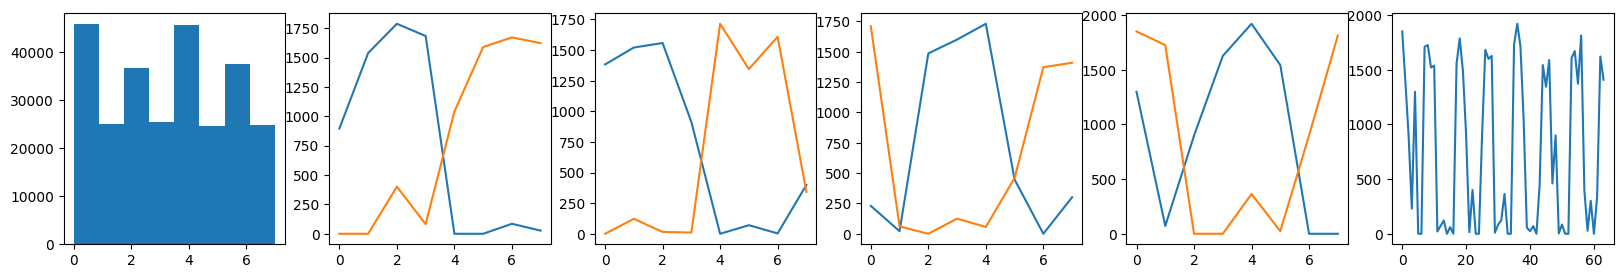

In [181]:
# ровный

name='00201_73.jpg'
chain_plots(name)

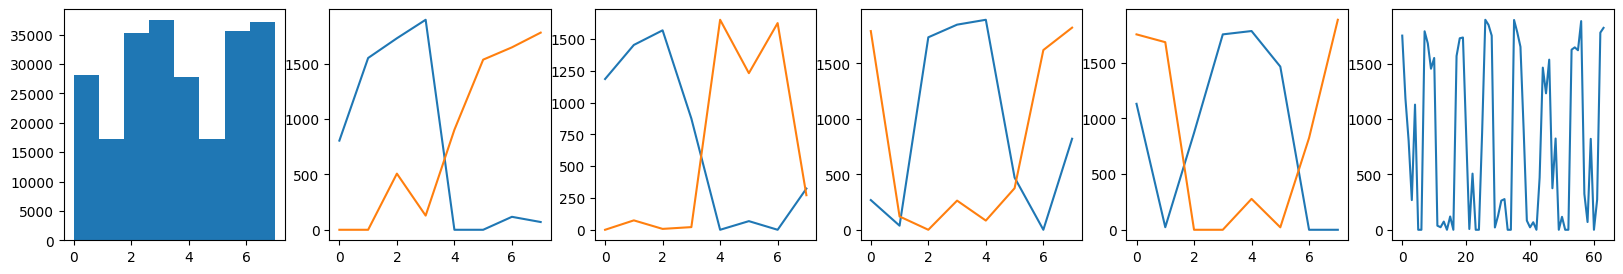

In [183]:
# наклон вправо

name='67205_2.jpg'
chain_plots(name)

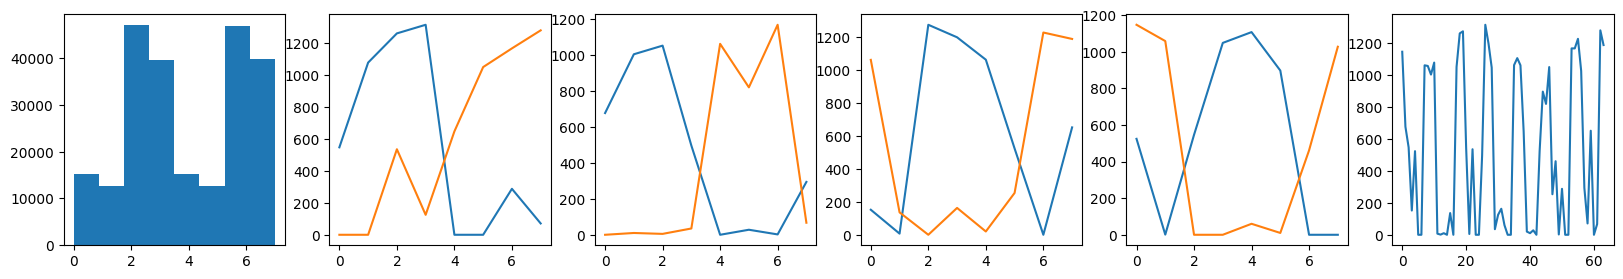

In [182]:
# вправо сильно

name='67205_3.jpg'
chain_plots(name)

## Hausford (fractal) dimention (done)

In [172]:
# ровный
name='00201_73.jpg'

# вправо сильно
# name='67205_3.jpg'

#  ровный
# name='62325_1_12.jpg'

# наклон вправо
# name='67205_2.jpg'


# name='1200px-Sierpinski_triangle.svg.png'

img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh=filters.threshold_otsu(Y)
binaryImage=Y>thresh

# input binary gray
data = ps.metrics.boxcount(binaryImage)

print(data.slope)
print(data.size)

  0%|          | 0/10 [00:00<?, ?it/s]

[1.3535606  1.32596583 1.50790388 1.79907042 1.87360903 1.90974811
 1.67732658 1.9010105  1.79963625 1.20147281]
[  10   17   31   56  100  178  317  565 1007 1793]


In [167]:
#  ровный
name='62325_1_12.jpg'

print(data.slope)
print(data.size)

[1.46491613 1.45394577 1.64921525 1.77987944 1.82542734 1.94531805
 1.75713949 1.88419096 1.71519948 1.22074576]
[  10   17   31   54   96  170  301  532  938 1655]


In [173]:
# ровный
name='00201_73.jpg'

print(data.slope)
print(data.size)

[1.3535606  1.32596583 1.50790388 1.79907042 1.87360903 1.90974811
 1.67732658 1.9010105  1.79963625 1.20147281]
[  10   17   31   56  100  178  317  565 1007 1793]


In [171]:
# вправо сильно
name='67205_3.jpg'

print(data.slope)
print(data.size)

[1.40425843 1.40082353 1.50812024 1.72938662 1.8735521  1.89669421
 1.64524277 1.90017944 1.79758528 1.19995489]
[  10   17   31   56  100  179  319  568 1013 1805]


In [169]:
# наклон вправо
name='67205_2.jpg'

print(data.slope)
print(data.size)

[1.44648689 1.40305334 1.52804519 1.752603   1.85378001 1.89106887
 1.69710726 1.9019273  1.74500652 1.20071097]
[  10   17   31   56  100  179  318  567 1010 1799]


## Height/width of the text (in progress)

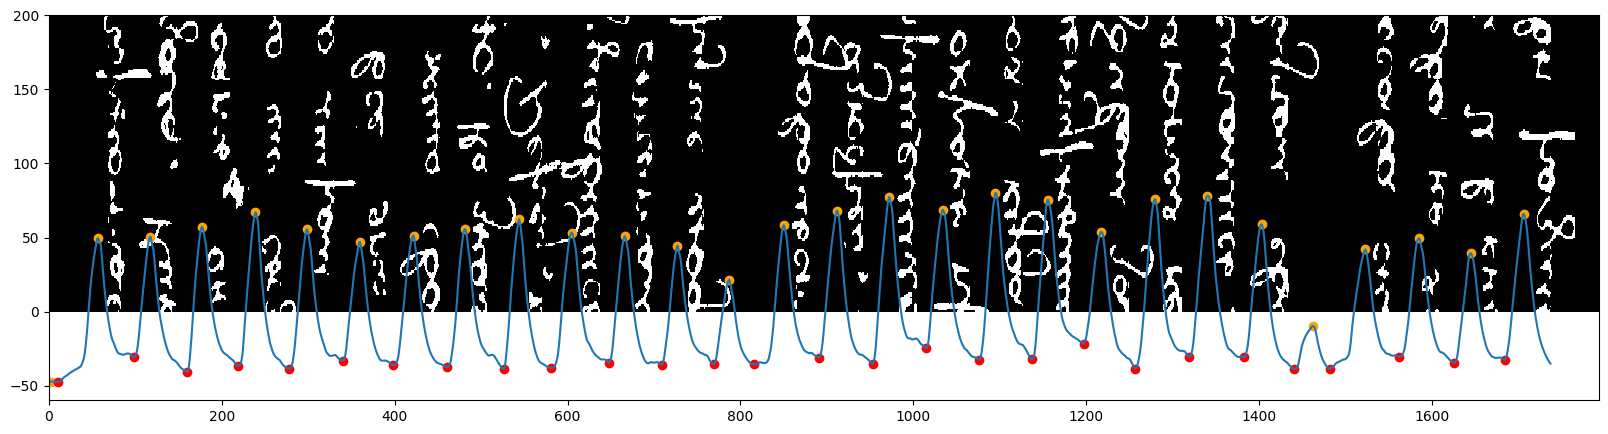

In [429]:
# ровный
name='00201_73.jpg'

# вправо сильно
# name='67205_3.jpg'

#  ровный
# name='62325_1_12.jpg'

# наклон вправо
# name='67205_2.jpg'

img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh=filters.threshold_otsu(Y)
binaryImage=Y>thresh

img=binaryImage

mean_pixel_column=[]
for i in range(img.shape[0]):
    pixels=[]
    for j in range(img.shape[1]):
        pixels.append(img[i,j])
    mean_pixel_column.append(np.mean(pixels))


# deriv=np.gradient(mean_pixel_column)*1e4
mean_pixel_column=np.array(mean_pixel_column)*1e3

fit1 = SimpleExpSmoothing(mean_pixel_column).fit(smoothing_level=0.1,optimized=False).fittedvalues

plt.figure(figsize=(20,5))
plt.pcolormesh(transform.rotate(img,90)[200:400],cmap='gray')
plt.plot(fit1*0.5-50)
# ax1.set_xlim(0,img.shape[0])

peaks_max=find_peaks(fit1,distance=50)[0]
plt.scatter(peaks_max, fit1[peaks_max]*0.5-50,color='orange')

peaks_min=find_peaks(-fit1,distance=40)[0]
plt.scatter(peaks_min, fit1[peaks_min]*0.5-50,color='red')
# min_extremax=argrelextrema(fit1, np.less)[0]


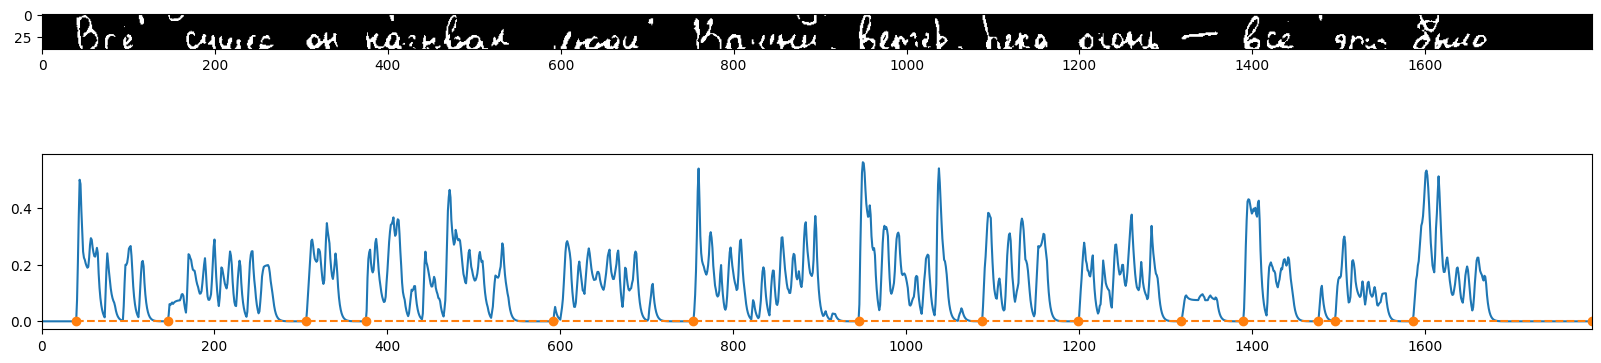

In [434]:
# ровный
# ровный
# ровный
name='00201_73.jpg'

# вправо сильно
# name='67205_3.jpg'

#  ровный
# name='62325_1_12.jpg'

# наклон вправо
# name='67205_2.jpg'

img=io.imread(name)

N_lines=30
height=60

k=5

(C, M, Y, K) = rgb2smyk(img)

thresh=filters.threshold_otsu(Y)
binaryImage=Y>thresh

img=binaryImage[k*height:(k+1)*height,:][20:]

mean_pixel_column=[]
for i in range(img.shape[1]):
    pixels=[]
    for j in range(img.shape[0]):
        pixels.append(img[j,i])
    mean_pixel_column.append(np.mean(pixels))


fit1 = SimpleExpSmoothing(mean_pixel_column).fit(smoothing_level=0.3,optimized=False).fittedvalues

zeros_fit=np.where(fit1<0.001)[0]
zeros_change_indices=np.where(np.diff(zeros_fit)>1)[0]
words_indices=zeros_fit[zeros_change_indices]
words_indices=np.append(words_indices,img.shape[1])

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,5))

ax2.plot(fit1)
ax2.plot(words_indices,np.zeros(len(words_indices)),'o--')
ax2.set_xlim(0,img.shape[1])

# plt.pcolormesh(img,cmap='gray')
ax1.imshow(img,cmap='gray')
# plt.ylim(-10,70)
# plt.xlim(0,img.shape[1])


peaks_min=find_peaks(-fit1,distance=70)[0]
# ax2.scatter(peaks_min, fit1[peaks_min],color='red')
# plt.scatter(peaks, fit1[peaks],color='orange')
# min_extremax=argrelextrema(fit1, np.less)[0]




In [386]:
zeros_fit

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,  133,  134,  135,  136,  137,  138,  139,  140,  141,
        142,  143,  144,  145,  146,  280,  281,  282,  283,  284,  285,
        286,  287,  288,  289,  290,  291,  292,  293,  294,  295,  296,
        297,  298,  299,  300,  301,  302,  303,  304,  305,  306,  356,
        357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
        368,  369,  370,  371,  372,  373,  374,  375,  552,  553,  554,
        555,  556,  557,  558,  559,  560,  561,  562,  563,  727,  728,
        729,  730,  744,  745,  746,  927,  928,  929,  930,  931,  932,
        933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
        944,  945, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085,
       1086, 1087, 1088, 1182, 1183, 1184, 1185, 11